# Week 04 seminar: Finetuning. 

In [3]:
import os
import time
import requests
from tqdm.auto import trange, tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

# charts and display libs
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

# pytorch 
import torch
import torchvision
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure that output below says `device=device(type='cuda')` - you will need CUDA for faster model runs
# If in Colab, we recommend that you go to Runtime -> Change Runtime Type -> GPU

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='1.13.1', torchvision.__version__='0.14.1', device=device(type='cuda'), torch.get_num_threads()=4


## TorchVision

[Torchvision](https://pytorch.org/vision/main/index.html) - part of PyTorch library with convenient tools and data for deep learning in visual domain.
- contains a number of popular vision [datasets](https://pytorch.org/vision/stable/datasets.html)
- preprocessing [tools](https://pytorch.org/vision/stable/transforms.html) 
- and most importantly, [pre-trained models](https://pytorch.org/vision/main/models.html).

# Datasets: Imagenet

![imagenet_tiles](https://i.imgur.com/n4QIrzF.jpeg)

Today we're going to use and fine-tune CNN based on weights pre-trained on ImageNet.

What is Imagenet?
- large size image classification dataset.
    - ImageNet-1K contains 1,281,167 training images, 50,000 validation images and 100,000 test images.
    - Full original dataset (ImageNet-21k) contains 14,197,122 images divided into 21,841 classes
    - Resolution varies, average resolution: 469x387 pixels
- built pre-2010 by [Fei-Fei Li](https://en.wikipedia.org/wiki/Fei-Fei_Li) at Princeton 
- made very popular by ImageNet Large Scale Visual Recognition Challenge (ILSVRC). See AlexNet moment: [chart](https://www.researchgate.net/figure/ImageNet-Competition-Results-50_fig1_329975404), [wiki](https://en.wikipedia.org/wiki/AlexNet), [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
-  still relevant; [accuracy history 2013 to date](https://paperswithcode.com/sota/image-classification-on-imagenet)
- More about Imagenet: http://image-net.org/,  https://en.wikipedia.org/wiki/ImageNet

In [9]:
# loading Imagenet class labels for interpreting classification results
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels = {int(k):v[1] for k, v in requests.get(LABELS_URL).json().items()}
print(len(imagenet_labels), '\n', list(imagenet_labels.items())[:5])

1000 
 [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


# Pretrained models: Resnet


Torchvision models classification models with benchmarks may be viewed [here.](https://pytorch.org/vision/main/models.html#classification)

For this seminar we're going to use Pytorch implementation of popular Resnet model.

In [10]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT) # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False);        # set the model to evaluation mode

In [ ]:
# view the model structure. Familiar layers are combined into 4 blocks
# note the last LINEAR layer named 'fc' that converts embeddings of size 512 into logits for 1000 Imagenet classes
model

### testing the pretrained model 1
test output dimensions with dummy inputs<br>
note that model inputs have to be 4D: (batch_size, color_channes, height, width)<br>
output is a 2D tensor of logits (batch_size, number_of_classes)

In [12]:
dummy_x = torch.randn(5, 3, 224, 224, device=device)  # dummy batch of 5 'images' sized 224x224 with 3 channels, created on GPU
result = model(dummy_x)
assert result.shape == (5, 1000)   # output is a 2D tensor of logits (batch_size, number_of_classes)

### testing the pretrained model 2. Predict class probabilities.

(224, 224)


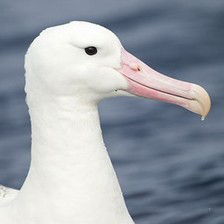

In [13]:
# loading image with PIL library
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alternative source
print(img.size)
img

In [14]:
# converting PIL image to torch.Tensor - detailed process
img_torch = torch.tensor(np.array(img), device=device)  # convert PIL image to np.array, then to torch.Tensor,
img_torch = img_torch.permute(2,0,1)  # reorder channels to move color to the front position, to match pytorch converntions
img_torch = img_torch / img_torch.max()  # scale to 0..1 

img_torch.shape, img_torch.device, img_torch.min().item(), img_torch.max().item()  # verify shape, device and range

(torch.Size([3, 224, 224]), device(type='cuda', index=0), 0.0, 1.0)

In [15]:
# converting PIL image to torch.Tensor - easy process
# PIL image to torch.Tensor can be converted with torchvision.transforms, equivalent tothe above code (more details below)
img_torch = transforms.ToTensor()(img)
img_torch.shape, img_torch.max(), img_torch.min()

(torch.Size([3, 224, 224]), tensor(1.), tensor(0.))

In [16]:
# Predicting image class with pretrained model


def predict_img(img, model, top_n=5):
    if isinstance(img, str):  
        Image.open(requests.get(url, stream=True).raw).convert('RGB')  # for loading images from url
        
    img_torch = transforms.ToTensor()(img)  # to torch.Tensor, reorder color channels, s|cale to 0..1 
    img_torch = transforms.Resize((224, 224))(img_torch)      # another useful transform to resize images
    img_torch = img_torch.unsqueeze(0)                        # add batch dimension (remember that model needs 4D input)
    img_torch = img_torch.to(device)                          # moving the tensor to device (presumably cuda, in initialized above)
    prediction = model(img_torch)                             # obtain prediction logits from the model
    probs = torch.nn.functional.softmax(prediction, dim=-1)   # convert logits into probabilities
    probs = probs.cpu().data.numpy()                          # convert CUDA tensor to numpy array 
    
    top_ix = probs.ravel().argsort()[-1: -top_n - 1: -1]      # get indices of most probable classes
    print (f'top-{top_n} classes:')                           # look up class label
    for l in top_ix:
        print (f"{probs.ravel()[l]:>6.2%}  {imagenet_labels[l].split(',')[0]}")


predict_img(img, model)

top-5 classes:
98.63%  albatross
 0.48%  spoonbill
 0.39%  American_egret
 0.22%  goose
 0.13%  crane


### testing the pretrained model 3: Images from unknown classes

Play with imahes from these and other (yours) URLS. Note how object outsize of imagenet classes confuse the net. Low probabilities in top classes are indications of model's low confidence.

In [ ]:
url= 'https://cdn5.vedomosti.ru/crop/image/2023/a/khwog/original-qkb.png?height=349&width=620'                    # modern version

# <TRY ANY OTHER IMAGES YOU LIKE>

web_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
print(web_img.size)
display(transforms.Resize((224, 224))(web_img))
predict_img(web_img, model)

## More Torchvision tools: Transforms and transform pipelines¶

You already used `transforms.ToTensor` and `transforms.Resize` above. There are many more at [Torchvision](https://pytorch.org/vision/stable/transforms.html). For easier application they are typically combined into pipelines. See examples below.

For more advanced tranforms (faster and compatible with tasks requiring mask or reference points), check out [Albumentations library](https://albumentations.ai/).

In [21]:
from torchvision import transforms

# Typical transform pipeline for test loop
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Optional: normalize imaged according to ImageNet standards
])

img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alt link
img_torch = transform_pipeline(img)

print(type(img_torch), img_torch.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


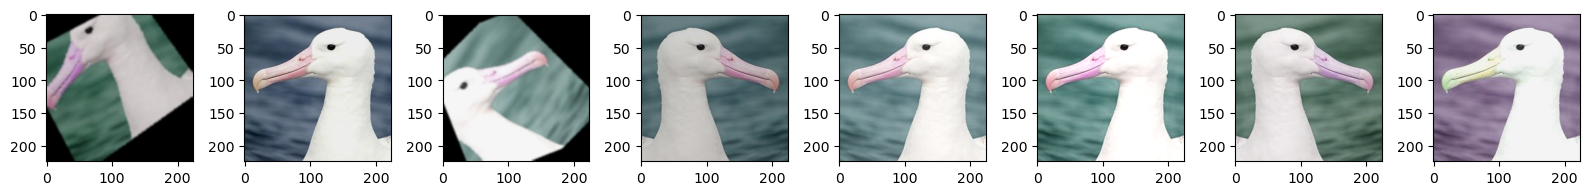

In [22]:
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alternative source

# Demo of augmentations for train pipeline

transform_pipeline_2 = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=25),
    ], p=0.5),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),  # not always applicable
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Optional: normalizes imaged according to ImageNet standards
])

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_2 = transform_pipeline_2(img)
    ax.imshow(img_2.permute(1, 2, 0))
plt.tight_layout()

# Classifying with CNN model's latent features
Pretrained image classification models learn extract image features that are useful in classification tasks. We need to get those features from outputs of the model's penultimate level and pass them to classifier. 
While this is not exactly a proper finetuning, this method is quick, rather robust and allows to classify unknown classes using quite small training sets (tens / hundreds of images).

### How to get features
features = activations before the very last Linear layer of the model (named `fc` in Resnet - check the model structure above.

During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [26]:
class Identity(torch.nn.Module):
    """replacement for the last model layer to deliver the unaltered inputs of the last layer"""

    def forward(self, x):
        return x
    
# it is practically same as torch.nn.Identity() - check https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Identity

In [27]:
# Create model clone with altered last layer
embedding_model = deepcopy(model)  # start with a clone of the original model
embedding_model.fc = Identity()    # redefine the last layer to be Identity|
embedding_model = embedding_model.to(device)  # move the result to CUDA

In [63]:
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg') # alt link
img_torch = transforms.ToTensor()(img).unsqueeze(0).to(device)
out = embedding_model(img_torch).cpu().data.numpy()
assert out.shape == (1, 512), "your output for single image should have shape (1, 512)"

# Starter problem: cat-dog classification
Your next task is to use a pre-trained model to distinguish between cats and dogs.
- viewed as imposible in 2000
- popular data science challenge problem in 2010
- warm-up task for students in 2020s <br>
![cat_meme](https://i.imgur.com/u1bubWv.jpeg)

In [37]:
# download the dataset
!wget https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip -O dogs_vs_cats_1000.zip

--2023-05-03 23:58:51--  https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|2a02:6b8::1d9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46394659 (44M) [application/zip]
Saving to: ‘dogs_vs_cats_1000.zip’

dogs_vs_cats_1000.z 100%[===================>]  44.25M   142MB/s    in 0.3s    

2023-05-03 23:58:51 (142 MB/s) - ‘dogs_vs_cats_1000.zip’ saved [46394659/46394659]



In [38]:
!unzip -qn dogs_vs_cats_1000.zip
!ls dogs_vs_cats_1000 | wc -l

2000


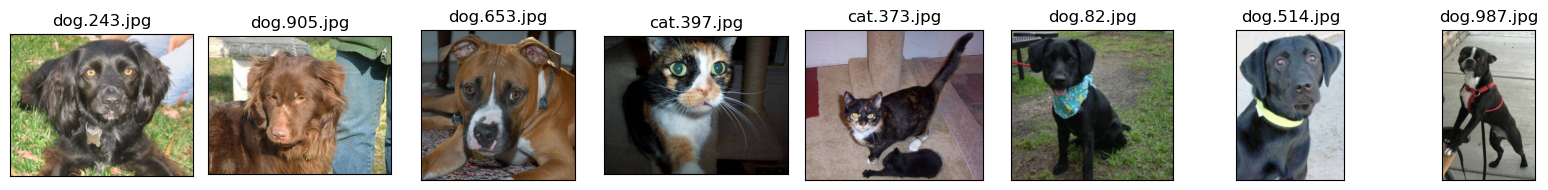

In [39]:
# Sample pets images
import random
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

fnames = [fn for fn in os.listdir('dogs_vs_cats_1000')]
for ax, fname in zip(axs.ravel(), random.choices(fnames, k=8)):
    img_ = Image.open(os.path.join('dogs_vs_cats_1000', fname))
    ax.imshow(img_)
    ax.set_title(f"{fname}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [ ]:
# Here we generate image embeddings using the activations before the last layer
# use batches to accelerate the process

X_ = []  # storage for batches embeddings
Y_ = []  # storage for batches labels

filenames = [fname for fname in os.listdir('dogs_vs_cats_1000')]
batch_size = 64
x_batch_list = []  # to accumulate batch components

with torch.no_grad():
    for i, fname in enumerate(tqdm(filenames)):
        img = Image.open(os.path.join("dogs_vs_cats_1000", fname))
        img_torch = transforms.ToTensor()(img.resize((224, 224)))
        x_batch_list.append(img_torch)
        Y_.append(1 if fname.startswith("cat") else 0)

        if len(x_batch_list) == batch_size or i >= len(filenames) - 1:
            x_batch = torch.stack(x_batch_list)
            # use your embedding model to produce embeddings vectors, convert result to numpy array
            # embeddings = <YOUR CODE>
            
            assert isinstance(embeddings,  torch.Tensor) 
            assert embeddings.ndim == 2 and embeddings.shape[1] == 512
            X_.append(embeddings)
            x_batch_list = []                

In [41]:
X = np.concatenate(X_, axis = 0)  # concatenate all batches' embeddings into single 2D array. 
Y = np.array(Y_[:len(X)])  # convert labels into np array; crop if we ended prematurely

print(X.shape, Y.shape, np.mean(Y))

assert X.ndim == 2 and X.shape[1] == 512   
assert X.shape[0] == len(filenames)
assert Y.ndim == 1 and Y.shape[0] == X.shape[0]
assert 0.49 <= np.mean(Y) <= 0.51

(2000, 512) (2000,) 0.5


### embeddings classification with ML-1 tools

In [42]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

* Train sklearn model, evaluate validation accuracy (should be >90%)

__Task 1 (2 points)__:<br>  
- write the code for cats/dogs classification using the embeddings created above. Use any classification tools that you learned. Reach at least 95% accuracy. __(1 point)__.  Try few different tools if accuracy is not high enough. <br>
(You may choose any classifier algorithm as long as it gets above 95% accuracy. To get the max grade here, you need to tune main hyperparameters of your chosen algorithm (e.g. k for KNN, tree depth, logreg C) depending on how many data points you have. )
- try this excercise with much smaller training set. Find the lowest train set size that you can at which you can still predict cat/dog class with 95% accuracy __(1 point)__ <br>
(note: exact threshold may depend on algorightm choice and train/test split. Show your effort in  experimenting with low train set sizes.)

In [ ]:
%%time 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

<YOUR CODE HERE>

Y_pred = ... <ALSO YOUR CODE>


print(f"accuracy = {(Y_pred == Y_test).sum() / Y_pred.shape[0]:.1%}")

## Torchvision Datasets
- Built-in datasets https://pytorch.org/vision/stable/datasets.html#built-in-datasets

- Datasets and Dataloaders at `torch.utils.data`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Torchvision classes for custom datasets  https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets

# Problem 2: Clasification of cat/dog breeds using Oxford pets dataset

The next problem is to classify specific cat / dog breeds from popular Oxford pets dataset. It is conveniently provided by Pytorch so loading and using it is very easy.

Dataset home page: https://www.robots.ox.ac.uk/~vgg/data/pets/

Available from Pytorch: https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet



In [43]:
# Loading train and test subsets of the dataset
# using simple transform for both slices

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='trainval', target_types='category', download=True, transform=test_transform)
test_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='test', target_types='category', download=True, transform=test_transform)

print("dataset sizes:", len(train_dataset), len(test_dataset))

print(train_dataset.classes)

dataset sizes: 3680 3669
['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [44]:
# create dataloaders to repack the datasets' data into batches
# read more

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("dataloader sizes:", len(train_dataloader), len(test_dataloader))

dataloader sizes: 58 58


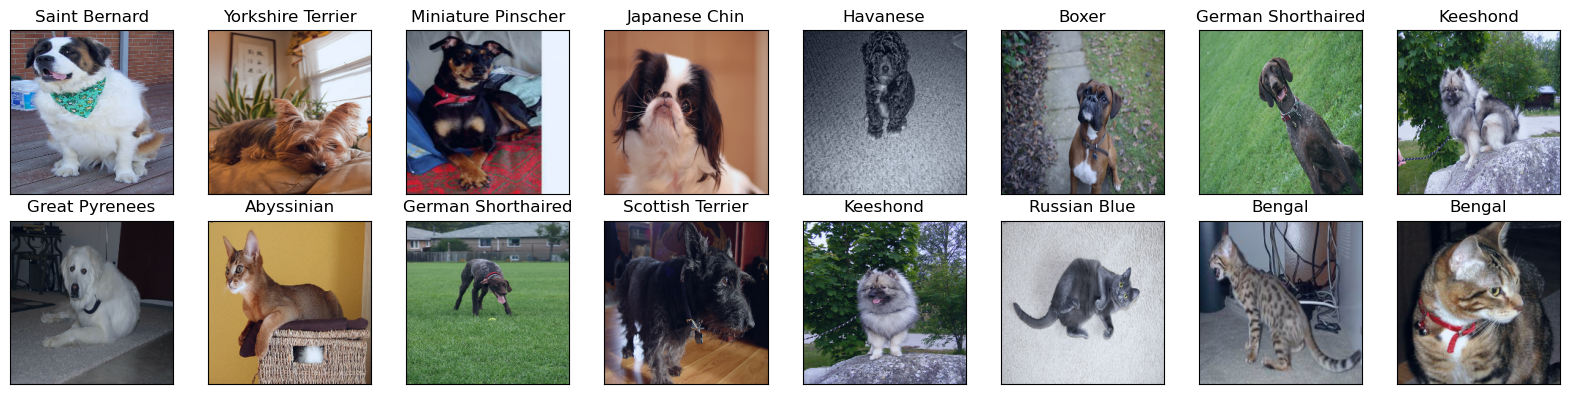

In [45]:
# Showing sample pets images
for x_batch, y_batch in train_dataloader:
    break  # Only get data from the 1st batch for now

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_ = x_batch[i].permute(1, 2, 0) # restoring dimensions order
    img_ -= img_.min().item()  # normalizing image to 0..1
    img_ /= img_.max().item()
    ax.imshow(img_)
    label = train_dataset.classes[y_batch[i]]
    ax.set_title(f"{label}")
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()

Remember that Imagenet includes quite a few cat and dog breeds among its classes. 

Let's try to predcit breeds with Imagenet-pretrained model without finetuning first

In [46]:
# Predicting breeds with Imagenet-pretrained model
Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)
        
Y_probs = torch.cat(Y_probs, axis=0)  # tensor with class probabilities
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 1000]))

In [57]:
# Output top 3 predictions for each class using pretrained CNN (no finetuning)
# Expect to see high accuracy (70-80%) in some classes, much lower overal, mismatch in label spaces.

results_list = {}

for i, cl in enumerate(test_dataset.classes):
    class_stats = {"true_label":cl}
    probs1 = Y_probs[np.where(Y_true == i)].mean(axis=0).numpy()
    top_ix = probs1.argsort()[-1:][::-1]
    class_stats
    for j, l in enumerate(top_ix):
        class_stats = {f"pred_1": imagenet_labels[l], 
                    f"prob_{1}": probs1.ravel()[l]}
    results_list[cl] = class_stats

df = pd.DataFrame(results_list).T.sort_values('prob_1', ascending=False)
float_cols = ['prob_1']
df.style.format('{:.2%}', subset=float_cols)

,pred_1,prob_1
Siamese,Siamese_cat,94.69%
Keeshond,keeshond,92.61%
Saint Bernard,Saint_Bernard,90.52%
Persian,Persian_cat,86.50%
Pomeranian,Pomeranian,84.32%
Samoyed,Samoyed,83.92%
Boxer,boxer,82.63%
Pug,pug,82.44%
Basset Hound,basset,79.27%
Leonberger,Leonberg,78.81%


### Finetuning CNN: classification layer only: 

__Task 2: (3 points)__:<br>
Complete the code below and reach at least 85% accuracy by training only the classification layer:

In [61]:
ft_model = deepcopy(model).to(device)

<YOUR CODE HERE>
# your task:
# 1) freeze all model parameters
# 2) replace model.fc with a new linear layer that has the appropriate number of outputs

assert all(not p.requires_grad for p in ft_model.parameters() if p not in set(ft_model.fc.parameters()))
assert ft_model.fc.out_features == len(train_dataset.classes)
assert ft_model.fc.weight.device == device, f"ft_model.fc must be on {device}"
assert ft_model.fc.weight.requires_grad

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.001)

In [ ]:
# train the finetuning model in a standard training loop. 

num_epochs = 10  # Adjust number of epochs if needed 

history = defaultdict(list)
for epoch in range(num_epochs):
    start_time = time.time()
    
    ft_model.train()
    train_losses = []
    pbar = tqdm(train_dataloader, leave=False)    
    for x_batch, y_batch in pbar:
        
        # calculate model predictions, calculate loss, make optimizer step 
        <YOUR CODE HERE>
        ...
        loss = ...
        
        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"
        
    ft_model.eval()
    val_losses = []
    val_cnt, val_correct = 0, 0
    pbar = tqdm(test_dataloader, leave=False)
    for x_batch, y_batch in pbar:
        
        # get model predictions, measure loss, collect data for accuracy calc
        <YOUR CODE HERE>
        y_pred = ...
        loss = ...
        
        val_losses.append(loss.item())
        val_cnt += y_batch.shape[0]
        val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    accuracy = val_correct / val_cnt
    history['train_loss'].append(train_loss) 
    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")
    
    if epoch > 2 and history['accuracy'][-1] < max(history['accuracy']):
        break
print(f"Best Accuracy = {max(history['accuracy']):.2%}")

In [85]:
# This part of finetuning alone should deliver at least 85% accuracy. 
assert accuracy > 0.85 

In [59]:
# Predicting breeds with finetuned model

Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = ft_model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)
        
Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 37]))

In [ ]:
# Measure Top1 prediction accuracy for each class

results_list = {}
total, correct = 0, 0

for i, cl in enumerate(test_dataset.classes):
    class_preds = np.where(Y_true == i)
    probs1 = Y_probs[class_preds].mean(axis=0).numpy()
    acc1 = probs1[i]
    class_stats = {"true_label":cl, 'acc1': acc1}
    total += class_preds[0].shape[0]
    correct += class_preds[0].shape[0] * acc1
    results_list[cl] = acc1
    
df = pd.Series(results_list).to_frame('acc1').sort_values('acc1', ascending=False)
df.style.format('{:.2%}', subset=['acc1'])

### Finetuning CNN: now unfreeze and train all layers: 

__task 3 (5 points)__: Based on the previous task, continue finetuning the model run by training all of its layers. Obtain at least 90% accuracy (macro average, as defined in the code).
To reach 90%, you will need to experiment with network and/or training code, start from using improvements from the list below:

Scoring:
- reaching 90% accuracy - __3 points__
- testing out all 4 of these improvements - __2 points__:
    - Hyperparameters optimization
    - Image augmentation
    - Pretrained model selection
    - Early stopping training at epoch with best metric and / or loading the weights of best epoch. [read about `state_dict`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict)
    
(you may not necessarily get spectacular results right away. Experiment and describe your actions and findings in a brief report in this notebook.)
- scoring above 90% -- __+1 BONUS point__ for every 1% improvement in accuracy above 90%

__Guidelines__: to improve quality of the finetuned model we can now train all of its layers.
- do this after initial training of classification layer
- set learning rate to much lower level to avoid explosion
- make all layers trainable using `requires_grad` param

In [ ]:
# Continue training with all layers involved

# <YOUR CODE to make all layers trainable>

assert all (p.requires_grad for p in ft_model.parameters())

optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.00003)  # reduce LR to avoid explosion

In [ ]:
<TRAIN MORE - COPY TRAINING CODE FROM ABOVE>

In [ ]:
<MEASURE RESULTS - COPY ACCURACY MEASUREMENT CODE FROM ABOVE>

In [ ]:
print(f"Overall Accuracy = {correct / total:.2%}")  # macro-averaged accuracy
assert correct / total >= 0.9

In [ ]:
<RUN EXPERIMENTS WITH IMPROVEMENTS>

# STUDENT'S REPORT

Please write a short report describing the steps you took to improve quality. It should be at least a short paragraph with 3-5 sentences and, optionally, any relevant numbers/charts, but there's no upper limit.

Here's what i did: <YOUR TEXT>

# Bonus task __(optional. 2 more points)__:

Notice that accuracy varies across breeds. Build confusion Propose improvements to the model finetuning process to improve minimal accuracy levels for all classes. Show the model runs.
Measure the improvement in terms of minimal accuracy and micro-averaged accuracy.

# EXTRA STUFF:


## Links:    
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
- [Activations Atlas](https://distill.pub/2019/activation-atlas/)
- more models from https://github.com/huggingface/pytorch-image-models
- Papers with code: benchmarks and model references. https://paperswithcode.com/sota/image-classification-on-imagenet